In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_absolute_error

In [65]:
train = pd.read_csv("train.csv")

In [66]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [67]:
train_ids = train['PassengerId']
train.drop(['PassengerId'], axis=1, inplace=True)

In [68]:
# Add just the last name as it might be important and remove full name
# There could be some cross contamination between cabin and last name?
#fam = train['Name'].str.split(n=1,expand=True)
#train['Family Name'] = fam[1]
train.drop(['Name'], axis=1, inplace=True)

In [69]:
# Remove any extra whitespace
train.columns = train.columns.str.replace(' ', '_')

In [70]:
print(train.head())
train.dtypes

  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0   
1      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0   
2     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0   
3     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0   
4      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported  
0        0.0           0.0     0.0     0.0        False  
1        9.0          25.0   549.0    44.0         True  
2     3576.0           0.0  6715.0    49.0        False  
3     1283.0         371.0  3329.0   193.0        False  
4       70.0         151.0   565.0     2.0         True  


HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
dtype: object

In [71]:
# Replacing missing homeplanets with the homeplanets of those in the same cabin This did not improve my results

#na_planets = train[train['HomePlanet'].isna()]['Cabin']
#found_planets = train.loc[train['Cabin'].isin(na_planets) 
#                          & ~train['Cabin'].isna() 
#                          & ~train['HomePlanet'].isna(), ['Cabin', 'HomePlanet']]
#merged_df = train.merge(found_planets, on='Cabin', how='left')
#merged_df['HomePlanet'] = merged_df['HomePlanet_y'].fillna(merged_df['HomePlanet_x'])
#cabin_planet_matched = merged_df.groupby(['Cabin'])['HomePlanet'].first().reset_index()
#train.update(cabin_planet_matched, overwrite=False)


In [72]:
# Replace all nan with 0 as its GXB prefered method

train.fillna(0, inplace=True)

In [73]:
len(train.loc[train['HomePlanet'] == 0])

201

In [74]:
# Try replacing 0 in VIP with False to set it to bool
train['VIP'].replace(0, False, inplace=True)
train['VIP'] = train['VIP'].astype(bool)

In [75]:
# Split X and y
X = train.drop('Transported', axis=1).copy()
y = train['Transported'].copy()

In [1]:
X_encode = pd.get_dummies(X, columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'])

NameError: name 'pd' is not defined

In [77]:
# data is balanced approx 50/50 so I will do normal split
X_train, X_test, y_train, y_test = train_test_split(X_encode, y)

In [28]:
# build a basic model without modifying parameters
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',eval_metric='aucpr', early_stopping_rounds=10, missing=1)
clf_xgb.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.85804
[1]	validation_0-aucpr:0.86471
[2]	validation_0-aucpr:0.87374
[3]	validation_0-aucpr:0.87408
[4]	validation_0-aucpr:0.87537
[5]	validation_0-aucpr:0.87479
[6]	validation_0-aucpr:0.87554
[7]	validation_0-aucpr:0.87655
[8]	validation_0-aucpr:0.87912
[9]	validation_0-aucpr:0.87987
[10]	validation_0-aucpr:0.88005
[11]	validation_0-aucpr:0.88100
[12]	validation_0-aucpr:0.88182
[13]	validation_0-aucpr:0.88190
[14]	validation_0-aucpr:0.88232
[15]	validation_0-aucpr:0.88239
[16]	validation_0-aucpr:0.88233
[17]	validation_0-aucpr:0.88290
[18]	validation_0-aucpr:0.88359
[19]	validation_0-aucpr:0.88356
[20]	validation_0-aucpr:0.88261
[21]	validation_0-aucpr:0.88317
[22]	validation_0-aucpr:0.88328
[23]	validation_0-aucpr:0.88337
[24]	validation_0-aucpr:0.88325
[25]	validation_0-aucpr:0.88313
[26]	validation_0-aucpr:0.88316
[27]	validation_0-aucpr:0.88329


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=1, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

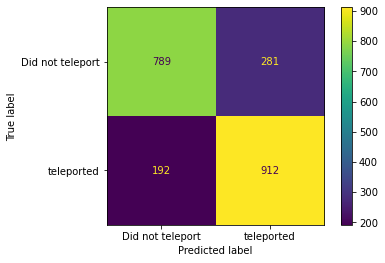

In [104]:
# check simple model confusion matrix, results aren't great
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=['Did not teleport', 'teleported'])

In [21]:
# optimize parameters with hyperparameterization, grid2 came after running 1 and refines the search by making params in the
# middle of their range static, and expanding the search for params at the max of their range

param_grid1 = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1,0.01,0.05],
    'gamma': [0,0.25,1.0],
    'reg_lambda': [0,1.0,10.0],
    'scale_pos_weight': [1,3,5]
}

param_grid2 = {
    'max_depth': [4],
    'learning_rate': [0.05,0.005,0.001],
    'gamma': [0.25],
    'reg_lambda': [0],
    'scale_pos_weight': [0.1,0.5,1]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective = 'binary:logistic',
                               subsample=0.9,
                               colsample_bytree=0.5,
                                early_stopping_rounds=10,
                                eval_metric='auc'
                               ),
    param_grid = param_grid2,
    scoring = 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 3
)

In [79]:
# round 1
optimal_params.fit(X_train,y_train, eval_set=[(X_test, y_test)], verbose=False)
optimal_params.best_params_

C:\Users\Admin\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 0,
 'scale_pos_weight': 1}

In [22]:
# round 2 we get the same values so we'll stick with that
optimal_params.fit(X_train,y_train, eval_set=[(X_test, y_test)], verbose=False)
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 0,
 'scale_pos_weight': 1}

In [78]:
# setup optimal model

xlf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0.25,
                         learning_rate=0.05,
                         max_depth=4,
                         reg_lambda=0,
                         scale_pos_weight=1,
                         colsample_bytree=0.5,
                           early_stopping_rounds=10,
                           eval_metric='aucpr')

xlf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.83454
[1]	validation_0-aucpr:0.84523
[2]	validation_0-aucpr:0.85121
[3]	validation_0-aucpr:0.85653
[4]	validation_0-aucpr:0.85806
[5]	validation_0-aucpr:0.85521
[6]	validation_0-aucpr:0.85138
[7]	validation_0-aucpr:0.85545
[8]	validation_0-aucpr:0.85721
[9]	validation_0-aucpr:0.85611
[10]	validation_0-aucpr:0.85808
[11]	validation_0-aucpr:0.85799
[12]	validation_0-aucpr:0.85772
[13]	validation_0-aucpr:0.85808
[14]	validation_0-aucpr:0.85918
[15]	validation_0-aucpr:0.85922
[16]	validation_0-aucpr:0.85918
[17]	validation_0-aucpr:0.85905
[18]	validation_0-aucpr:0.85914
[19]	validation_0-aucpr:0.85880
[20]	validation_0-aucpr:0.85821
[21]	validation_0-aucpr:0.85962
[22]	validation_0-aucpr:0.85998
[23]	validation_0-aucpr:0.86084
[24]	validation_0-aucpr:0.86108
[25]	validation_0-aucpr:0.86143
[26]	validation_0-aucpr:0.86206
[27]	validation_0-aucpr:0.86227
[28]	validation_0-aucpr:0.86274
[29]	validation_0-aucpr:0.86245
[30]	validation_0-aucpr:0.86262
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0, ...)

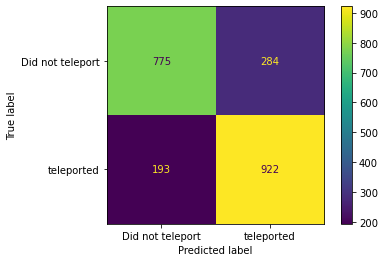

In [79]:
plot_confusion_matrix(xlf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Did not teleport', 'teleported'])

In [80]:
# now to run on test data

test = pd.read_csv("test.csv")
test_ids = test['PassengerId']
test.drop(['PassengerId'], axis=1, inplace=True)

#fam = test['Name'].str.split(n=1,expand=True)
#test['Family Name'] = fam[1]
test.drop(['Name'], axis=1, inplace=True)
test.columns = test.columns.str.replace(' ', '_')

# planet replace for test
#na_planets = test[test['HomePlanet'].isna()]['Cabin']
#found_planets = test.loc[test['Cabin'].isin(na_planets) 
#                            & ~test['Cabin'].isna() 
#                            & ~test['HomePlanet'].isna(), ['Cabin', 'HomePlanet']]
#merged_df = test.merge(found_planets, on='Cabin', how='left')
#merged_df['HomePlanet'] = merged_df['HomePlanet_y'].fillna(merged_df['HomePlanet_x'])
#cabin_planet_matched = merged_df.groupby(['Cabin'])['HomePlanet'].first().reset_index()
#test.update(cabin_planet_matched, overwrite=False)

test.fillna(0, inplace=True)

test['VIP'].replace(0, False, inplace=True)
test['VIP'] = test['VIP'].astype(bool)

print(test.head())

test_encode = pd.get_dummies(test, columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'])

missing = set(X_encode.columns) - set(test_encode)
for c in missing:
    test_encode[c] = 0
test_encode = test_encode[X_encode.columns]

  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0      Earth      True  G/3/S  TRAPPIST-1e  27.0  False          0.0   
1      Earth     False  F/4/S  TRAPPIST-1e  19.0  False          0.0   
2     Europa      True  C/0/S  55 Cancri e  31.0  False          0.0   
3     Europa     False  C/1/S  TRAPPIST-1e  38.0  False          0.0   
4      Earth     False  F/5/S  TRAPPIST-1e  20.0  False         10.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  
0        0.0           0.0     0.0     0.0  
1        9.0           0.0  2823.0     0.0  
2        0.0           0.0     0.0     0.0  
3     6652.0           0.0   181.0   585.0  
4        0.0         635.0     0.0     0.0  


In [81]:
predictions = xlf_xgb.predict(test_encode)
predictions

array([1, 0, 1, ..., 1, 1, 1])

In [82]:
predictions = predictions.astype(bool)
predictions

array([ True, False,  True, ...,  True,  True,  True])

In [83]:
# positive percentage
(sum(predictions)/len(predictions))*100

55.108721066167874

In [84]:
submission = pd.read_csv("sample_submission.csv")
submission['Transported'] = predictions
submission.to_csv("submission4.csv", index=False)